# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

* Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

* The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston

In [2]:
class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features, min_leaf):
        self.X = X
        self.y = y
        self.n_trees = n_trees
        self.n_features = n_features
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        self.estimators = []
        
        for _ in range(n_trees):
            self.train_single_estimator()
        

    def predict(self, X):
        
        preds = np.zeros(X.shape[0])

        for estimator, _, features_mask in self.estimators:
            preds += estimator.predict(X[:, features_mask])

        return preds / self.n_trees

    def oob_mse(self):
        
        oob_mses = []

        for sample_idx in range(self.X.shape[0]):
            sample = np.expand_dims(self.X[sample_idx], axis=0)
            label = self.y[sample_idx]
            sample_preds = []

            for estimator, samples_mask, feature_mask in self.estimators:
                if sample_idx not in samples_mask:
                    sample_preds.append(estimator.predict(sample[:, feature_mask]))

            if sample_preds:
                mean_oob_prediction = np.mean(sample_preds)
                oob_mses.append(np.square(mean_oob_prediction - label))
        
        return np.mean(oob_mses)
    
    
    def train_single_estimator(self):
        clf = DecisionTreeRegressor(min_samples_leaf=self.min_leaf)
        subset_x, subset_y, samples_mask, features_mask = self.get_random_samples_for_estimator()
        clf.fit(subset_x, subset_y)
        self.estimators.append((clf, samples_mask, features_mask))



    def get_random_samples_for_estimator(self):
        # Select random samples (with replacement)
        sample_mask = np.random.choice(self.X.shape[0], size=self.sample_sz, replace=True)
        sample_x = self.X[sample_mask]
        sample_y = self.y[sample_mask]

        features_mask = np.random.choice(self.X.shape[1], size=self.n_features, replace=False)
        sample_x = sample_x[:, features_mask]
        
        return sample_x, sample_y, sample_mask, features_mask
    
    def get_params(self):
        return {"n_trees": self.n_trees,
                "n_features": self.n_features,
                "sample_sz": self.sample_sz,
                "min_leaf": self.min_leaf}



In [3]:
from sklearn.datasets import load_boston

boston_ds = load_boston()
data = boston_ds.get('data')
target = boston_ds.get('target')



/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Cali

In [4]:
rf = TreeEnsemble(data, target, 1, 50, 5, 1)

In [5]:
from sklearn.metrics import mean_squared_error

rf_preds = rf.predict(data)

mean_squared_error(y_true=target, y_pred=rf_preds)

37.85750988142292

In [6]:
rf.oob_mse()

41.916630196936545

In [7]:
best_oob_forest = None
best_oob_mse = np.inf

for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(data, target, n, sz, 5, min_leaf)
      mse = forest.oob_mse()
      
      if mse < best_oob_mse:
        best_oob_mse = mse
        best_oob_forest = forest
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))


n_trees:1, sz:50, min_leaf:1 --- oob mse: 40.84143790849674
n_trees:1, sz:50, min_leaf:5 --- oob mse: 39.071678973866646
n_trees:1, sz:100, min_leaf:1 --- oob mse: 28.680676328502415
n_trees:1, sz:100, min_leaf:5 --- oob mse: 54.78340118245541
n_trees:1, sz:300, min_leaf:1 --- oob mse: 35.94533807829181
n_trees:1, sz:300, min_leaf:5 --- oob mse: 58.17332166810328
n_trees:1, sz:500, min_leaf:1 --- oob mse: 30.65994623655914
n_trees:1, sz:500, min_leaf:5 --- oob mse: 32.64513033222399
n_trees:5, sz:50, min_leaf:1 --- oob mse: 49.60533118686868
n_trees:5, sz:50, min_leaf:5 --- oob mse: 26.900739991208887
n_trees:5, sz:100, min_leaf:1 --- oob mse: 28.144038202678964
n_trees:5, sz:100, min_leaf:5 --- oob mse: 26.765614317139832
n_trees:5, sz:300, min_leaf:1 --- oob mse: 29.69305958754785
n_trees:5, sz:300, min_leaf:5 --- oob mse: 26.886253830854706
n_trees:5, sz:500, min_leaf:1 --- oob mse: 49.66039482405399
n_trees:5, sz:500, min_leaf:5 --- oob mse: 28.798833418329316
n_trees:10, sz:50, mi

In [8]:
print(f"Best MSE: {best_oob_mse}")
print(f"Best params: {best_oob_forest.get_params()}")

Best MSE: 14.177815039763665
Best params: {'n_trees': 50, 'n_features': 5, 'sample_sz': 500, 'min_leaf': 5}


/Users/adahan/opt/anaconda3/envs/py4dp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


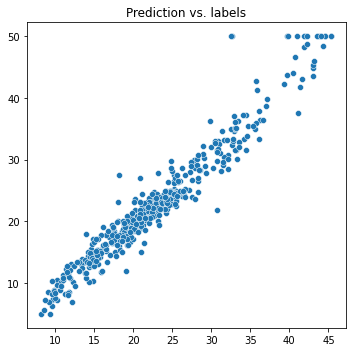

In [9]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.scatterplot(best_oob_forest.predict(data), target)
plt.title("Prediction vs. labels")
plt.tight_layout()

## 2. Implementing AdaBoost From Scratch (30 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?



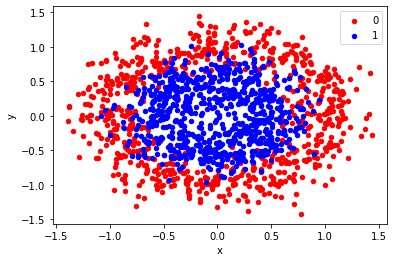

In [12]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [13]:
from sklearn.model_selection import train_test_split

seed=0
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=seed)

In [14]:
class AdaBoost():
    def __init__(self, X, y, n_learners, get_weak_learner_method):
        self.X = X

        # Modify class 0 to -1 (for later calculations)
        y_modified = y.copy()
        y_modified[y_modified==0] = -1
        
        self.y = y_modified
        self.n_learners = n_learners
        self.get_weak_learner_method = get_weak_learner_method
        self.estimators = []
        self.sample_weights = np.ones_like(y) / X.shape[0] # Initialize uniform weights for all samples
        
        for _ in range(n_learners):
            self.train_single_estimator()
        

    def predict(self, X):
        
        preds = np.zeros(X.shape[0])

        for estimator, alpha in self.estimators:
            preds += alpha * estimator.predict(X)

        preds[preds >= 0] = 1
        preds[preds < 0] = 0
        return preds
    
    
    def train_single_estimator(self):
        estimator = self.get_weak_learner_method()
        
        # Re-sample the dataset based on weights
        weighted_sampling = np.random.choice(self.X.shape[0], size=self.X.shape[0], replace=True, p=self.sample_weights)
        weighted_X = self.X[weighted_sampling]
        weighted_y = self.y[weighted_sampling]

        # Fit - predict
        estimator.fit(weighted_X, weighted_y)
        preds = estimator.predict(self.X)

        # Evaluate errors, estimator weight and new samples weights
        weighted_errors = self.sample_weights[np.abs(preds - self.y) > 0]
        epsilon = np.sum(weighted_errors)
        alpha = 0.5 * np.log((1-epsilon) / epsilon)

        new_weights = self.sample_weights * np.exp(-alpha * self.y * preds)
        # Normalize and update weights
        self.sample_weights = new_weights / (np.sum(new_weights))

        self.estimators.append((estimator, alpha))
    
    def get_params(self):
        return {"n_learners": self.n_learners}





Results for 1 learners:



<Figure size 576x576 with 0 Axes>

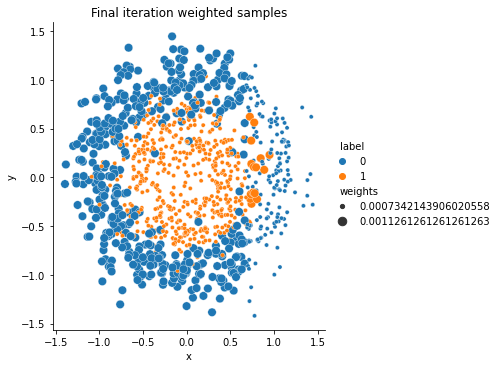

Train accuracy: 0.6053333333333333
Test accuracy: 0.6346666666666667


Results for 2 learners:



<Figure size 576x576 with 0 Axes>

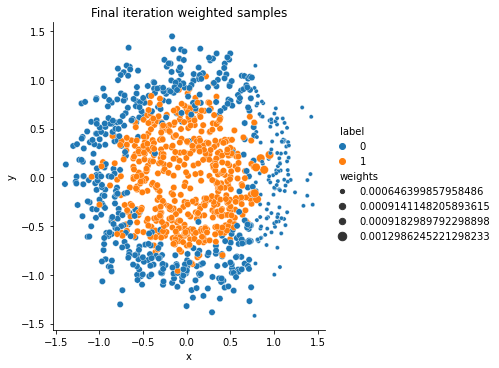

Train accuracy: 0.5182222222222223
Test accuracy: 0.44533333333333336


Results for 3 learners:



<Figure size 576x576 with 0 Axes>

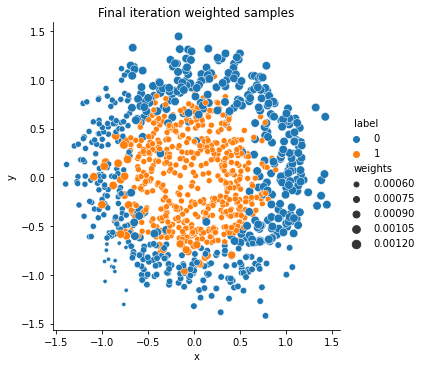

Train accuracy: 0.6986666666666667
Test accuracy: 0.7306666666666667


Results for 5 learners:



<Figure size 576x576 with 0 Axes>

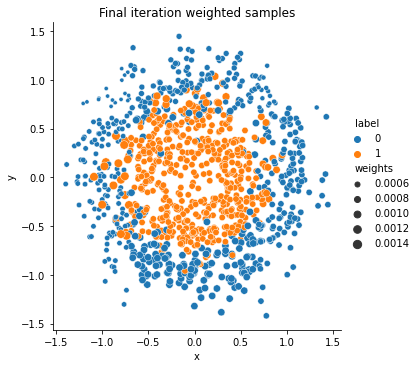

Train accuracy: 0.7973333333333333
Test accuracy: 0.7893333333333333


Results for 10 learners:



<Figure size 576x576 with 0 Axes>

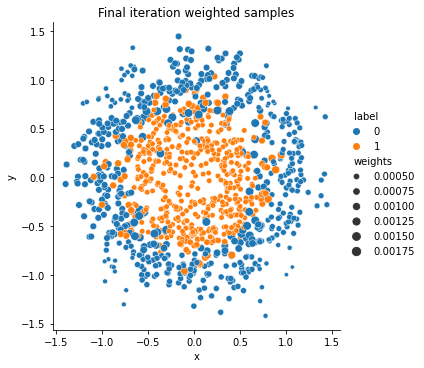

Train accuracy: 0.8746666666666667
Test accuracy: 0.8506666666666667


Results for 50 learners:



<Figure size 576x576 with 0 Axes>

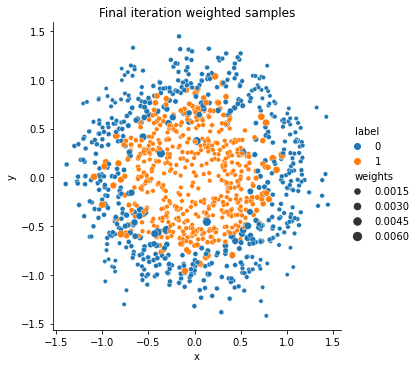

Train accuracy: 0.8951111111111111
Test accuracy: 0.864


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def get_weak_estimator():
    return DecisionTreeClassifier(max_depth=1, random_state=0)


ada_models = {}

for n in [1, 2, 3, 5, 10, 50]:
    clf = AdaBoost(X=train_x, y=train_y, n_learners=n, get_weak_learner_method=get_weak_estimator)

    print(f"\n\nResults for {n} learners:\n")

    # Visualize the final samples
    temp_df = DataFrame(train_x, columns=['x', 'y'])
    temp_df['label'] = train_y
    temp_df['weights'] = clf.sample_weights

    plt.figure(figsize=(8, 8))
    
    g = sns.relplot(data=temp_df, x="x", y="y", hue="label", size="weights")
    plt.title('Final iteration weighted samples')
    plt.show()

    # Print train / test accuracy
    train_acc = accuracy_score(train_y, clf.predict(train_x))
    test_acc = accuracy_score(test_y, clf.predict(test_x))
    print(f"Train accuracy: {train_acc}\nTest accuracy: {test_acc}")

    # Save trained model
    ada_models[n] = clf
    

##### How does the overall train set accuracy changes with $n$?

We see that for the low n values the accuracy has high variance, it seems like every additional estimator is changing constantly (also in negative directions).

For higher n values we see that the variance is smaller but the improvement between iterations is smaller as well.

Let's plot the accuracy over # of learners for 1-100 learners:

In [20]:
acc_data = []

for n in range(1, 100):
    clf = AdaBoost(X=train_x, y=train_y, n_learners=n, get_weak_learner_method=get_weak_estimator)

    # Get train acc
    train_acc = accuracy_score(train_y, clf.predict(train_x))
    acc_data.append((n, train_acc))

Text(0.5, 1.0, 'Train precision over number of learners')

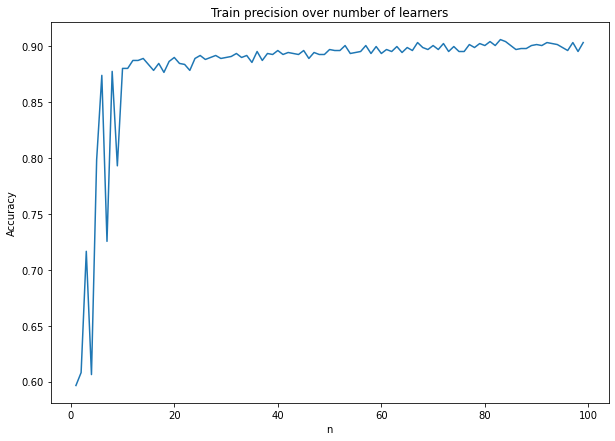

In [21]:
plt.figure(figsize=(10, 7))
acc_df = DataFrame(acc_data, columns=['n', 'Accuracy'])
sns.lineplot(data=acc_df, x='n', y='Accuracy')
plt.title("Train precision over number of learners")

##### Does the model start to overfit at some point?

For the for n_learners we tested initially - [1, 2, 3, 5, 10, 50]


It doesn't seem like we're overfitting yet (based on the diffs of the train vs. test accuracy - printed under each sample weights plot)

I believe that for higher number of learners we will overfit (based on the above graph I would guess somewhere around 150+ learners), let's try to test this assumption:

In [24]:
for n in range(1, 100, 5):
    clf = AdaBoost(X=train_x, y=train_y, n_learners=n, get_weak_learner_method=get_weak_estimator)

    print(f"\n\nResults for {n} learners:")

    # Print train / test accuracy
    train_acc = accuracy_score(train_y, clf.predict(train_x))
    test_acc = accuracy_score(test_y, clf.predict(test_x))
    print(f"Train accuracy: {train_acc}\nTest accuracy: {test_acc}")



Results for 1 learners:
Train accuracy: 0.6053333333333333
Test accuracy: 0.6346666666666667


Results for 6 learners:
Train accuracy: 0.7955555555555556
Test accuracy: 0.792


Results for 11 learners:
Train accuracy: 0.8844444444444445
Test accuracy: 0.8613333333333333


Results for 16 learners:
Train accuracy: 0.8862222222222222
Test accuracy: 0.8586666666666667


Results for 21 learners:
Train accuracy: 0.888
Test accuracy: 0.856


Results for 26 learners:
Train accuracy: 0.8906666666666667
Test accuracy: 0.8586666666666667


Results for 31 learners:
Train accuracy: 0.8906666666666667
Test accuracy: 0.856


Results for 36 learners:
Train accuracy: 0.8862222222222222
Test accuracy: 0.8533333333333334


Results for 41 learners:
Train accuracy: 0.8933333333333333
Test accuracy: 0.864


Results for 46 learners:
Train accuracy: 0.8933333333333333
Test accuracy: 0.856


Results for 51 learners:
Train accuracy: 0.8968888888888888
Test accuracy: 0.8613333333333333


Results for 56 learner

It seems that for higher number of learners, somewhere after 30-50 learners we are having variance in the test results and certain degregation in the results (which sometimes improve a little bit), I believe that above these number we have a certain level of overfitting and we are also adding additional model complexity levels due to higher number of learners, without a decent improvement in the results.

## 3. Boosting Trees from Scratch (40 points)
* Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [17]:
class L2Boost():
    def __init__(self, n_learners, learning_rate=0.01, max_depth=1):
        
        self.X = None
        self.y = None
        self.target_mean = None
        self.accumulated_preds = None

        self.n_learners = n_learners
        self.lr = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.mse = []
    
    def fit(self, X, y):

        self.X = X
        self.y = y
        self.target_mean = np.mean(y)
        self.accumulated_preds = np.ones_like(y) * self.target_mean # Initialize predictions to mean(target)

        for _ in range(self.n_learners):
            self.train_single_estimator()

    def predict(self, X):
        
        # Create array in the shape of X full of the base mean value (target_mean)
        preds = np.ones_like(X.shape[0]) * self.target_mean

        # Apply the predictions per estimator on the data
        for estimator in self.estimators:
            preds += self.lr * estimator.predict(X)

        return preds
    
    
    def train_single_estimator(self):
        
        # Evaluate residuals
        residuals = self.y - self.accumulated_preds
        
        # Train current estimator
        estimator = DecisionTreeRegressor(max_depth=1, random_state=0)
        estimator.fit(self.X, residuals)
        
        # Update accumulated prediction
        residual_preds = estimator.predict(self.X)
        self.accumulated_preds += self.lr * residual_preds

        # Maintain MSE log
        self.mse.append(mean_squared_error(y_true=self.y, y_pred=self.accumulated_preds))

        # Save current estimator
        self.estimators.append(estimator)
    
    def get_params(self):
        return {"n_learners": self.n_learners}



##### Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000

In [ ]:
from sklearn.datasets import load_boston

boston_ds = load_boston()
data = boston_ds.get('data')
target = boston_ds.get('target')

In [19]:
seed=0

train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=seed)

In [20]:
logspace_10000 = np.unique(np.logspace(0, 3, endpoint=True, dtype=np.int64))

mse_results = []

for learners in logspace_10000:
    clf = L2Boost(n_learners=learners)
    clf.fit(X=train_x, y=train_y)
    
    train_preds = clf.predict(train_x)
    train_mse = mean_squared_error(y_true=train_y, y_pred=train_preds)
    
    test_preds = clf.predict(test_x)    
    test_mse = mean_squared_error(y_true=test_y, y_pred=test_preds)
    mse_results.append({'learners': learners, 'train_mse': train_mse, 'test_mse': test_mse})


In [21]:
mse_results_df = pd.DataFrame(mse_results)
mse_results_df.set_index('learners', inplace=True)
mse_results_df.head()

,train_mse,test_mse
learners,,
1,84.341529,81.030405
2,83.555301,80.490976
3,82.782569,79.905149
4,82.019867,79.384129
5,81.269815,78.840055


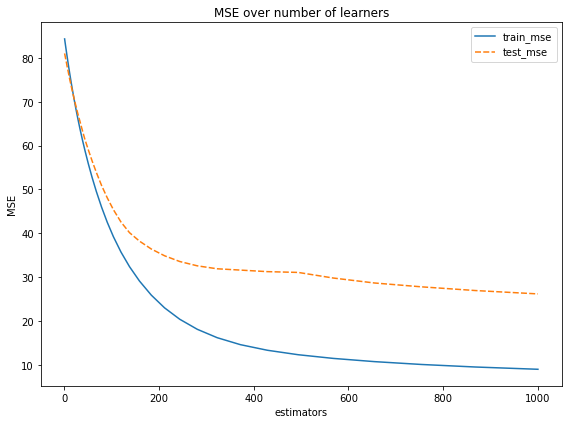

In [22]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=mse_results_df)
plt.title('MSE over number of learners')
plt.xlabel('estimators')
plt.ylabel('MSE')
plt.tight_layout()

##### What is the optimal value of `n_trees`? of learning rate?

Let's perform a search on a decent range of parameters:

In [23]:
params_grid = dict()
params_grid['n_learners'] = [50, 100, 200, 500, 1000, 1500, 2000]
params_grid['learning_rate'] = [0.01, 0.03, 0.05, 0.1]

results = []

for n in params_grid.get('n_learners'):
    for lr in params_grid.get('learning_rate'):
        
        clf = L2Boost(n_learners=n, learning_rate=lr)
        clf.fit(train_x, train_y)
        
        train_preds = clf.predict(train_x)
        train_mse = mean_squared_error(y_true=train_y, y_pred=train_preds)
        
        test_preds = clf.predict(test_x)    
        test_mse = mean_squared_error(y_true=test_y, y_pred=test_preds)

        results.append({'n_learners': n, 'learning_rate': lr, 'train_mse': train_mse, 'test_mse': test_mse})

In [24]:
results_df = pd.DataFrame(results)
results_df.sort_values('test_mse').head(10).reset_index()

,index,n_learners,learning_rate,train_mse,test_mse
0,20,1500,0.01,7.717787,24.749013
1,13,500,0.03,7.680482,24.750920
2,11,200,0.10,6.964097,24.882189
3,24,2000,0.01,7.000614,24.998904
4,14,500,0.05,6.458671,25.392024
5,17,1000,0.03,6.091484,25.608672
6,7,100,0.10,8.890519,25.653907
7,21,1500,0.03,5.300420,25.846999
8,18,1000,0.05,5.090803,25.903880
9,10,200,0.05,8.897799,25.941724


As I see it, I would go with the model in the 7th row above, with the params:
- n_learners: 100	
- learning_rate: 0.10

The results for this model are:
- Train MSE: 8.890519	
- Test MSE: 25.653907

I would take this model as I don't see any benifit from taking the top other 6 models becuase:
- They are more complex (200-2000 trees)
- The KPIs benefit on the test is not big compared to the 100 trees model I chose
- The train MSE is closer to the test MSE in the model I chose (which makes me believe it will have better and more "stable" results in production).

##### Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?

In [25]:
models = dict()

dtr_results = []

for max_depth in [1, 2, 4, 6, 8, 10, 16, 32, None]:

    dtr = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    dtr.fit(train_x, train_y)
    
    train_preds = dtr.predict(train_x)
    train_mse = mean_squared_error(y_true=train_y, y_pred=train_preds)
    
    test_preds = dtr.predict(test_x)    
    test_mse = mean_squared_error(y_true=test_y, y_pred=test_preds)

    dtr_results.append({'max_depth': max_depth, 'train_mse': train_mse, 'test_mse': test_mse})

    models[str(max_depth)] = dtr

dtr_results_df = pd.DataFrame(dtr_results)
dtr_results_df.sort_values('test_mse').reset_index()

,index,max_depth,train_mse,test_mse
0,5,10.0,0.442309,31.146938
1,6,16.0,0.002451,31.460610
2,7,32.0,0.000000,32.416373
3,8,NaN,0.000000,32.416373
4,4,8.0,1.420117,33.378728
5,1,2.0,23.270738,35.406216
6,3,6.0,3.922801,35.407038
7,2,4.0,9.020704,35.877983
8,0,1.0,44.832590,61.382030


We can easily see that each of the DecisionTreeRegressor model different options tend to overfit pretty quickly.

This is due to the fact that the results on the test set are worse than our model (and the train is almost perfect in most of the cases).

Which means that our model out-performs the DecisionTreeRegressor (out of the different max_depths we tested)



##### Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [29]:
class L2BoostV2():
    def __init__(self, n_learners, learning_rate=0.05, max_depth=1):
        
        self.X = None
        self.y = None
        self.target_mean = None
        self.accumulated_preds = None

        self.n_learners = n_learners
        self.lr = learning_rate
        self.max_depth = max_depth
        self.estimators = []
        self.mse = []
        
        # For early stop
        self.prev_mse = None
    
    def fit(self, train_x, train_y, validation_x, validation_y, early_stop=True):

        self.X = train_x
        self.y = train_y
        self.target_mean = np.mean(self.y)
        
        self.accumulated_preds = np.ones_like(self.y) * self.target_mean # Initialize predictions to mean(target)

        # Training with early stop
        best_mse = np.inf
        best_mse_iteration = 0
        iters_no_improvement = 0
        
        current_iteration = 0
        for _ in range(self.n_learners):
            self.train_single_estimator()
            
            validation_preds = self.predict(validation_x)
            current_validation_mse = np.mean(np.square(validation_y - validation_preds))

            # If improved save best iteration and reset counters
            if current_validation_mse < best_mse:
                best_mse = current_validation_mse
                best_mse_iteration = current_iteration
                iters_no_improvement = 0

            # If not, increase counter and stop if needed
            else:
                iters_no_improvement += 1

                if early_stop and iters_no_improvement >= 10:
                    print(f"Early stopped after {current_iteration + 1} iterations due to no improvement on the validation set in the last 10 iterations")
                    self.estimators = self.estimators[:best_mse_iteration]
                    return
            
            current_iteration += 1


    def predict(self, X):
        
        # Create array in the shape of X full of the base mean value (target_mean)
        preds = np.ones_like(X.shape[0]) * self.target_mean

        # Apply the predictions per estimator on the data
        for estimator in self.estimators:
            preds += self.lr * estimator.predict(X)

        return preds
    
    
    def train_single_estimator(self):
        
        # Evaluate residuals
        residuals = self.y - self.accumulated_preds
        
        # Train current estimator
        estimator = DecisionTreeRegressor(max_depth=1, random_state=0)
        estimator.fit(self.X, residuals)
        
        # Update accumulated prediction
        residual_preds = estimator.predict(self.X)
        self.accumulated_preds += self.lr * residual_preds

        # Maintain MSE log
        self.mse.append(mean_squared_error(y_true=self.y, y_pred=self.accumulated_preds))

        # Save current estimator
        self.estimators.append(estimator)



In [30]:
train_v2_x, validation_x, train_v2_y, validation_y = train_test_split(train_x, train_y, test_size=0.2, random_state=seed)

In [31]:
clf = L2BoostV2(n_learners=20000)
clf.fit(train_x=train_v2_x, train_y=train_v2_y, validation_x=validation_x, validation_y=validation_y)
    
train_preds = clf.predict(train_v2_x)
train_mse = mean_squared_error(y_true=train_v2_y, y_pred=train_preds)
    
test_preds = clf.predict(test_x)    
test_mse = mean_squared_error(y_true=test_y, y_pred=test_preds)

print(f"Results:\nTrain MSE - {train_mse}\nTest MSE - {test_mse}")


Early stopped after 289 iterations due to no improvement on the validation set in the last 10 iterations
Results:
Train MSE - 7.250576075583925
Test MSE - 23.39583014418062
